In [239]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import shapiro

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import xgboost as xgb

In [98]:
df = pd.read_csv('Avg_CRU.csv')
df.head()

,time,lat,lon,timeseries-tas-monthly-mean
0,1901-01-16,26.25,-122.75,NaN
1,1901-01-16,26.25,-122.25,NaN
2,1901-01-16,26.25,-121.75,NaN
3,1901-01-16,26.25,-121.25,NaN
4,1901-01-16,26.25,-120.75,NaN


In [99]:
df

,time,lat,lon,timeseries-tas-monthly-mean
0,1901-01-16,26.25,-122.75,NaN
1,1901-01-16,26.25,-122.25,NaN
2,1901-01-16,26.25,-121.75,NaN
3,1901-01-16,26.25,-121.25,NaN
4,1901-01-16,26.25,-120.75,NaN
...,...,...,...,...
6644347,2021-12-16,47.75,-73.25,-8.400001
6644348,2021-12-16,47.75,-72.75,-8.500000
6644349,2021-12-16,47.75,-72.25,-9.000000
6644350,2021-12-16,47.75,-71.75,-9.500000


In [100]:
ncounts = pd.DataFrame([df.isna().mean()]).T
ncounts

,0
time,0.000000
lat,0.000000
lon,0.000000
timeseries-tas-monthly-mean,0.182037


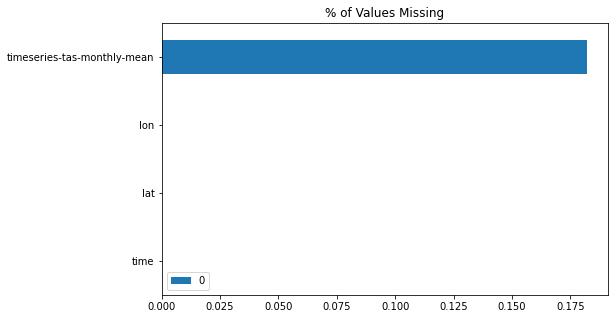

In [101]:
ncounts = pd.DataFrame([df.isna().mean()]).T
ncounts.plot(
    kind="barh", figsize=(8, 5), title="% of Values Missing"
)
plt.show()

## How many missing values per observation?

In [102]:
nacols = ['timeseries-tas-monthly-mean']

In [103]:
df["n_missing"] = df[nacols].isna().sum(axis=1)
df

,time,lat,lon,timeseries-tas-monthly-mean,n_missing
0,1901-01-16,26.25,-122.75,NaN,1
1,1901-01-16,26.25,-122.25,NaN,1
2,1901-01-16,26.25,-121.75,NaN,1
3,1901-01-16,26.25,-121.25,NaN,1
4,1901-01-16,26.25,-120.75,NaN,1
...,...,...,...,...,...
6644347,2021-12-16,47.75,-73.25,-8.400001,0
6644348,2021-12-16,47.75,-72.75,-8.500000,0
6644349,2021-12-16,47.75,-72.25,-9.000000,0
6644350,2021-12-16,47.75,-71.75,-9.500000,0


<AxesSubplot:title={'center':'Number of Missing Values per Sample'}>

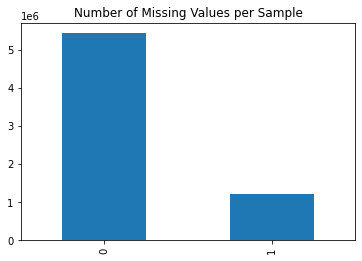

In [104]:
df["n_missing"].value_counts().plot(
    kind="bar", title="Number of Missing Values per Sample"
)

## Do we see an imbalance in missing values when splitting by other features?

In [105]:
df.groupby("timeseries-tas-monthly-mean")["n_missing"].mean()

timeseries-tas-monthly-mean
-25.600000    0.0
-25.400000    0.0
-25.300001    0.0
-25.200000    0.0
-25.000000    0.0
             ... 
 36.000000    0.0
 36.100002    0.0
 36.200000    0.0
 36.500000    0.0
 36.600002    0.0
Name: n_missing, Length: 619, dtype: float64

In [106]:
[sum([i]) for i in df.groupby("timeseries-tas-monthly-mean")["n_missing"].mean().values.tolist() if i > 0.0]

[]

In [107]:
basic_stats_nan_values = df.groupby("timeseries-tas-monthly-mean")["n_missing"].agg(['mean','count'])
basic_stats_nan_values

,mean,count
timeseries-tas-monthly-mean,,
-25.600000,0.0,1
-25.400000,0.0,1
-25.300001,0.0,1
-25.200000,0.0,1
-25.000000,0.0,1
...,...,...
36.000000,0.0,1
36.100002,0.0,5
36.200000,0.0,1


In [108]:
basic_stats_nan_values[basic_stats_nan_values['count'] > 1]

,mean,count
timeseries-tas-monthly-mean,,
-24.900000,0.0,2
-24.800001,0.0,2
-24.700000,0.0,3
-24.600000,0.0,6
-24.500000,0.0,3
...,...,...
35.700000,0.0,7
35.800000,0.0,8
35.900000,0.0,2


## Prep - Create Tag Columns with Missing Indicators

In [109]:
missing_tag_df = df[nacols].isna()
missing_tag_df.columns = \
    [f"{c}_missing" for c in missing_tag_df.columns]

In [110]:
df = pd.concat([df, missing_tag_df], axis=1)
df

,time,lat,lon,timeseries-tas-monthly-mean,n_missing,timeseries-tas-monthly-mean_missing
0,1901-01-16,26.25,-122.75,NaN,1,True
1,1901-01-16,26.25,-122.25,NaN,1,True
2,1901-01-16,26.25,-121.75,NaN,1,True
3,1901-01-16,26.25,-121.25,NaN,1,True
4,1901-01-16,26.25,-120.75,NaN,1,True
...,...,...,...,...,...,...
6644347,2021-12-16,47.75,-73.25,-8.400001,0,False
6644348,2021-12-16,47.75,-72.75,-8.500000,0,False
6644349,2021-12-16,47.75,-72.25,-9.000000,0,False
6644350,2021-12-16,47.75,-71.75,-9.500000,0,False


In [111]:
df.loc[df['timeseries-tas-monthly-mean_missing'] == False, ['timeseries-tas-monthly-mean_missing']]

,timeseries-tas-monthly-mean_missing
20,False
21,False
22,False
23,False
27,False
...,...
6644347,False
6644348,False
6644349,False
6644350,False


In [112]:
lr = LinearRegression()

X_to_use = df.loc[df['timeseries-tas-monthly-mean_missing'] == False, ['timeseries-tas-monthly-mean_missing']]
X_to_use.rename({'False': 0}, axis=0, inplace=True)
X_to_pred = df.loc[df['timeseries-tas-monthly-mean_missing'] == True, ['timeseries-tas-monthly-mean_missing']]
X_to_pred.rename({'True': 1}, axis=0, inplace=True)

y_to_use = df.loc[df["timeseries-tas-monthly-mean"].notna(), ['timeseries-tas-monthly-mean']].values
y_to_pred = df.loc[df["timeseries-tas-monthly-mean"].isna(), ['timeseries-tas-monthly-mean']].values

lr.fit(X_to_use, y_to_use)
lr.score(X_to_use, y_to_use)

preds = lr.predict(X_to_use)[:, 0]

mean_squared_error(y_to_use, preds, squared=True)

108.60310904469937

In [113]:
df["temperature_ms_mean_imp"] = df["timeseries-tas-monthly-mean"].fillna(
    df["timeseries-tas-monthly-mean"].mean()
)

df.loc[df['timeseries-tas-monthly-mean'].isna()] \
    [["timeseries-tas-monthly-mean", "temperature_ms_mean_imp"]] \
    .head(5)

,timeseries-tas-monthly-mean,temperature_ms_mean_imp
0,NaN,11.65202
1,NaN,11.65202
2,NaN,11.65202
3,NaN,11.65202
4,NaN,11.65202


In [114]:
df["temperature_ms_median_imp"] = df["timeseries-tas-monthly-mean"].fillna(
    df["timeseries-tas-monthly-mean"].median()
)

df.loc[df['timeseries-tas-monthly-mean'].isna()] \
    [["timeseries-tas-monthly-mean", "temperature_ms_mean_imp", 'temperature_ms_median_imp']] \
    .head(5)

,timeseries-tas-monthly-mean,temperature_ms_mean_imp,temperature_ms_median_imp
0,NaN,11.65202,12.7
1,NaN,11.65202,12.7
2,NaN,11.65202,12.7
3,NaN,11.65202,12.7
4,NaN,11.65202,12.7


## GroupBy Fill
        Use the average value grouped by a different feature
        As an example we will use the audio_mode feature

In [115]:
sd_mean_map = df.groupby("lat")["timeseries-tas-monthly-mean"] \
    .mean().to_dict()
sd_mean_map

{26.25: 21.233176114818967,
 26.75: 21.43042375524277,
 27.25: 21.0777309160365,
 27.75: 20.875159256850978,
 28.25: 20.540826007072845,
 28.75: 20.467670841896233,
 29.25: 20.188318196036697,
 29.75: 19.844072886590244,
 30.25: 19.333405394113065,
 30.75: 18.926470427747834,
 31.25: 18.563927554439722,
 31.75: 18.33325413043484,
 32.25: 18.151621859159228,
 32.75: 17.74356873865897,
 33.25: 17.063432452390813,
 33.75: 16.362015621155383,
 34.25: 15.562465731509294,
 34.75: 15.127836095461586,
 35.25: 14.630175178575579,
 35.75: 14.119036114529884,
 36.25: 13.5155626613352,
 36.75: 13.071688494190406,
 37.25: 12.254316995935906,
 37.75: 11.41216438221806,
 38.25: 11.081992634523502,
 38.75: 10.703102161555039,
 39.25: 10.30067968534871,
 39.75: 9.905452126448811,
 40.25: 9.6434400193458,
 40.75: 9.076266106741748,
 41.25: 8.592987226684414,
 41.75: 8.15576469214929,
 42.25: 7.751029179279773,
 42.75: 7.605963350100789,
 43.25: 7.3377636499870205,
 43.75: 6.761908058407899,
 44.25: 6.34

In [116]:
sd_mean_series = df['timeseries-tas-monthly-mean'].map(sd_mean_map)
sd_mean_series

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
6644347   NaN
6644348   NaN
6644349   NaN
6644350   NaN
6644351   NaN
Name: timeseries-tas-monthly-mean, Length: 6644352, dtype: float64

In [117]:
df["timeseries_ms_mode_imp"] = \
    df["timeseries-tas-monthly-mean"].fillna(sd_mean_series)
df

,time,lat,lon,timeseries-tas-monthly-mean,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,timeseries_ms_mode_imp
0,1901-01-16,26.25,-122.75,NaN,1,True,11.652020,12.700000,NaN
1,1901-01-16,26.25,-122.25,NaN,1,True,11.652020,12.700000,NaN
2,1901-01-16,26.25,-121.75,NaN,1,True,11.652020,12.700000,NaN
3,1901-01-16,26.25,-121.25,NaN,1,True,11.652020,12.700000,NaN
4,1901-01-16,26.25,-120.75,NaN,1,True,11.652020,12.700000,NaN
...,...,...,...,...,...,...,...,...,...
6644347,2021-12-16,47.75,-73.25,-8.400001,0,False,-8.400001,-8.400001,-8.400001
6644348,2021-12-16,47.75,-72.75,-8.500000,0,False,-8.500000,-8.500000,-8.500000
6644349,2021-12-16,47.75,-72.25,-9.000000,0,False,-9.000000,-9.000000,-9.000000
6644350,2021-12-16,47.75,-71.75,-9.500000,0,False,-9.500000,-9.500000,-9.500000


In [118]:
df[df['timeseries-tas-monthly-mean_missing'] == True][['lat', 'lon', 'timeseries_ms_mode_imp']].head(5)

,lat,lon,timeseries_ms_mode_imp
0,26.25,-122.75,NaN
1,26.25,-122.25,NaN
2,26.25,-121.75,NaN
3,26.25,-121.25,NaN
4,26.25,-120.75,NaN


In [119]:
df.dtypes

time                                    object
lat                                    float64
lon                                    float64
timeseries-tas-monthly-mean            float64
n_missing                                int64
timeseries-tas-monthly-mean_missing       bool
temperature_ms_mean_imp                float64
temperature_ms_median_imp              float64
timeseries_ms_mode_imp                 float64
dtype: object

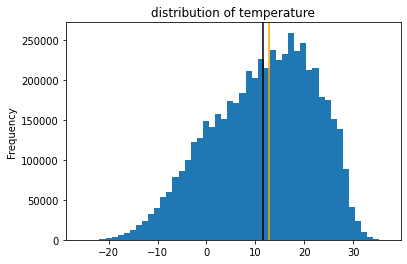

In [120]:
ax = df['timeseries-tas-monthly-mean'] \
    .plot(kind='hist', bins=50,
          title='distribution of temperature')
ax.axvline(df['timeseries-tas-monthly-mean'].mean(),
           color='black')
ax.axvline(df['timeseries-tas-monthly-mean'].median(),
           color='orange')

<AxesSubplot:ylabel='Frequency'>

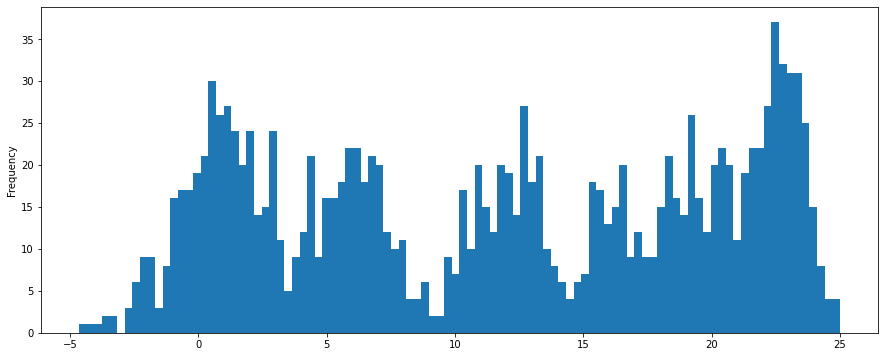

In [121]:
df.groupby('time')['timeseries-tas-monthly-mean'].mean().plot(kind='hist', bins=100, figsize=(15, 6))

<AxesSubplot:xlabel='time'>

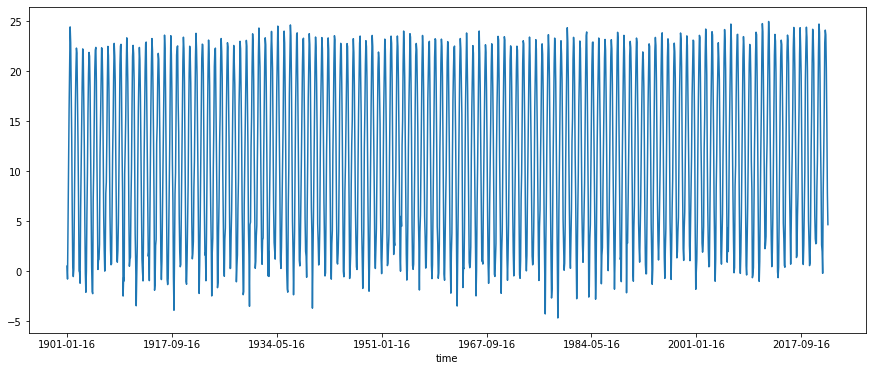

In [122]:
df.groupby('time')['timeseries-tas-monthly-mean'].mean().plot(figsize=(15, 6))

In [123]:
df.groupby('time')['timeseries-tas-monthly-mean'].mean()

time
1901-01-16     0.531472
1901-02-15    -0.762811
1901-03-16     5.054662
1901-04-16    10.079909
1901-05-16    16.190409
                ...    
2021-08-16    23.684424
2021-09-16    20.296126
2021-10-16    14.725060
2021-11-16     7.841010
2021-12-16     4.680684
Name: timeseries-tas-monthly-mean, Length: 1452, dtype: float64

<AxesSubplot:xlabel='time'>

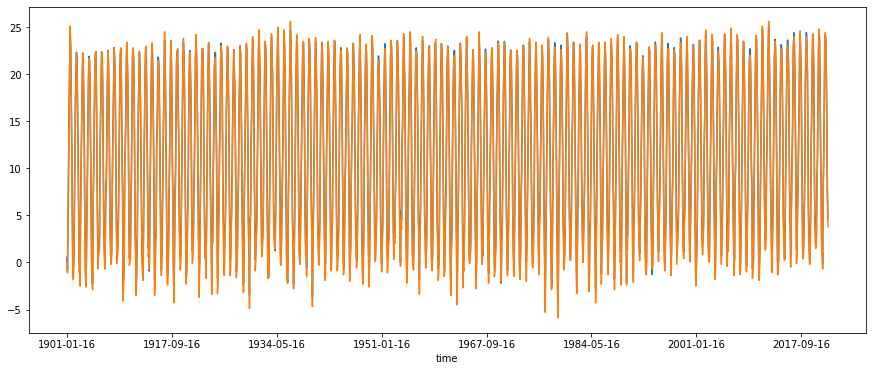

In [124]:
#df.groupby('time')['timeseries-tas-monthly-mean'].sum().plot(kind='hist', bins=100, figsize=(15, 6))
df.groupby('time')['timeseries-tas-monthly-mean'].mean().plot(figsize=(15, 6))
df.groupby('time')['timeseries-tas-monthly-mean'].median().plot(figsize=(15, 6))

In [125]:
from sklearn.impute import SimpleImputer

imptr = SimpleImputer(strategy="mean", add_indicator=False)
df_imp = imptr.fit_transform(df['timeseries-tas-monthly-mean'].values.reshape(-1, 1))
df_imp = pd.DataFrame(df_imp, columns=['timeseries-tas-monthly-mean'])
df_imp

,timeseries-tas-monthly-mean
0,11.652020
1,11.652020
2,11.652020
3,11.652020
4,11.652020
...,...
6644347,-8.400001
6644348,-8.500000
6644349,-9.000000
6644350,-9.500000


In [126]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_imputer = IterativeImputer(max_iter=10)
df_iterimp = it_imputer.fit_transform(df['timeseries-tas-monthly-mean'].values.reshape(-1, 1))
df_iterimp = pd.DataFrame(df_iterimp, columns=['timeseries-tas-monthly-mean'])
df_iterimp

,timeseries-tas-monthly-mean
0,11.652020
1,11.652020
2,11.652020
3,11.652020
4,11.652020
...,...
6644347,-8.400001
6644348,-8.500000
6644349,-9.000000
6644350,-9.500000


In [127]:
!git clone https://github.com/analokmaus/kuma_utils.git

fatal: destination path 'kuma_utils' already exists and is not an empty directory.


In [128]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [129]:
lgbm_imtr = LGBMImputer(n_iter=100)
df_lgbm_imtr = lgbm_imtr.fit_transform(df[['timeseries-tas-monthly-mean']])
df_lgbm_imtr = pd.DataFrame(df_lgbm_imtr, columns=['timeseries-tas-monthly-mean'])
df_lgbm_imtr

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


,timeseries-tas-monthly-mean
0,11.343924
1,11.343924
2,11.343924
3,11.343924
4,11.343924
...,...
6644347,-8.400001
6644348,-8.500000
6644349,-9.000000
6644350,-9.500000


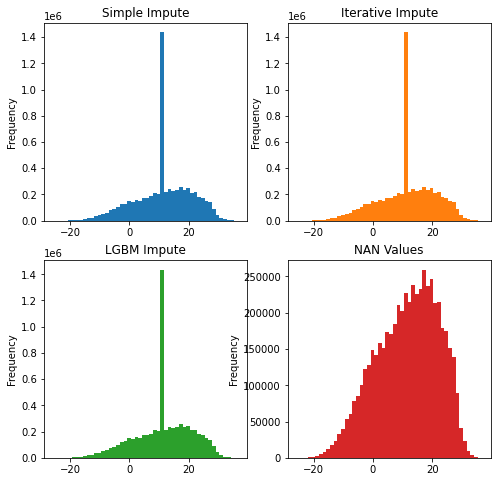

In [130]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

df_imp['timeseries-tas-monthly-mean'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute',
         color=color_pal[0])

df_iterimp['timeseries-tas-monthly-mean'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute',
         color=color_pal[1])

df_lgbm_imtr['timeseries-tas-monthly-mean'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='LGBM Impute',
         color=color_pal[2])

df['timeseries-tas-monthly-mean'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='NAN Values',
         color=color_pal[3])
plt.show()

In [131]:
df.shape

(6644352, 9)

In [132]:
df['time']

0          1901-01-16
1          1901-01-16
2          1901-01-16
3          1901-01-16
4          1901-01-16
              ...    
6644347    2021-12-16
6644348    2021-12-16
6644349    2021-12-16
6644350    2021-12-16
6644351    2021-12-16
Name: time, Length: 6644352, dtype: object

In [133]:
df_copy = df.loc[(df['time'] >= '1901-01-16') & (df['time'] < '2021-01-16')]

In [134]:
df_copy['time']

0          1901-01-16
1          1901-01-16
2          1901-01-16
3          1901-01-16
4          1901-01-16
              ...    
6589435    2020-12-16
6589436    2020-12-16
6589437    2020-12-16
6589438    2020-12-16
6589439    2020-12-16
Name: time, Length: 6589440, dtype: object

In [135]:
df_copy.shape

(6589440, 9)

In [136]:
df_copy.isnull().sum()

time                                         0
lat                                          0
lon                                          0
timeseries-tas-monthly-mean            1199520
n_missing                                    0
timeseries-tas-monthly-mean_missing          0
temperature_ms_mean_imp                      0
temperature_ms_median_imp                    0
timeseries_ms_mode_imp                 1199520
dtype: int64

In [137]:
df_copy.rename(columns={'timeseries-tas-monthly-mean': 'temperature'}, inplace=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\3443624648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.rename(columns={'timeseries-tas-monthly-mean': 'temperature'}, inplace=True)


In [138]:
df_copy['time'] = pd.to_datetime(df_copy['time'])
df_copy['year'] = df_copy['time'].dt.year
df_copy['month'] = df_copy['time'].dt.month
df_copy['quarter'] = df_copy['time'].dt.quarter

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\3525016679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['time'] = pd.to_datetime(df_copy['time'])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\3525016679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['year'] = df_copy['time'].dt.year
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\3525016679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [139]:
df_copy.loc[(df_copy['year'] >= 1901) & (df_copy['year'] < 2022), :]

,time,lat,lon,temperature,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,timeseries_ms_mode_imp,year,month,quarter
0,1901-01-16,26.25,-122.75,NaN,1,True,11.652020,12.700000,NaN,1901,1,1
1,1901-01-16,26.25,-122.25,NaN,1,True,11.652020,12.700000,NaN,1901,1,1
2,1901-01-16,26.25,-121.75,NaN,1,True,11.652020,12.700000,NaN,1901,1,1
3,1901-01-16,26.25,-121.25,NaN,1,True,11.652020,12.700000,NaN,1901,1,1
4,1901-01-16,26.25,-120.75,NaN,1,True,11.652020,12.700000,NaN,1901,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6589435,2020-12-16,47.75,-73.25,-8.300000,0,False,-8.300000,-8.300000,-8.300000,2020,12,4
6589436,2020-12-16,47.75,-72.75,-8.400001,0,False,-8.400001,-8.400001,-8.400001,2020,12,4
6589437,2020-12-16,47.75,-72.25,-8.700000,0,False,-8.700000,-8.700000,-8.700000,2020,12,4
6589438,2020-12-16,47.75,-71.75,-9.200000,0,False,-9.200000,-9.200000,-9.200000,2020,12,4


In [140]:
df_copy.dtypes

time                                   datetime64[ns]
lat                                           float64
lon                                           float64
temperature                                   float64
n_missing                                       int64
timeseries-tas-monthly-mean_missing              bool
temperature_ms_mean_imp                       float64
temperature_ms_median_imp                     float64
timeseries_ms_mode_imp                        float64
year                                            int64
month                                           int64
quarter                                         int64
dtype: object

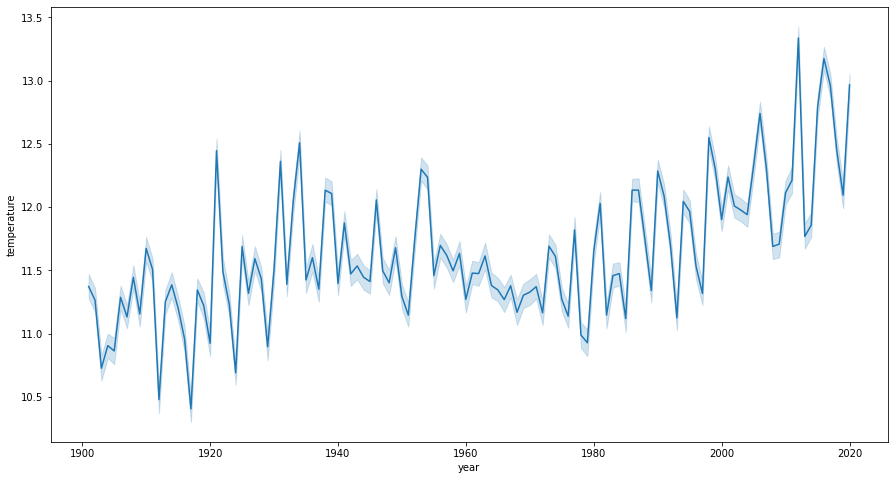

In [141]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_copy, x='year', y='temperature')
plt.show()

In [142]:
df_copy['time'].min(), df_copy['time'].max()

(Timestamp('1901-01-16 00:00:00'), Timestamp('2020-12-16 00:00:00'))

In [143]:
df_copy['time'].describe(datetime_is_numeric=True)

count                          6589440
mean     1960-12-30 14:59:59.999999712
min                1901-01-16 00:00:00
25%                1931-01-08 06:00:00
50%                1960-12-31 12:00:00
75%                1990-12-23 18:00:00
max                2020-12-16 00:00:00
Name: time, dtype: object

In [290]:
frame_out = df_copy.dropna(axis=0)

In [293]:
frame_out

,lat,lon,temperature,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,year,month,quarter,modified_z_scores
20,26.25,-112.75,16.700000,0,False,16.700000,16.700000,1901,1,1,0.350390
21,26.25,-112.25,16.500000,0,False,16.500000,16.500000,1901,1,1,0.332870
22,26.25,-111.75,16.500000,0,False,16.500000,16.500000,1901,1,1,0.332870
23,26.25,-111.25,17.300001,0,False,17.300001,17.300001,1901,1,1,0.402948
27,26.25,-109.25,17.600000,0,False,17.600000,17.600000,1901,1,1,0.429227
...,...,...,...,...,...,...,...,...,...,...,...
6589435,47.75,-73.25,-8.300000,0,False,-8.300000,-8.300000,2020,12,4,-1.839545
6589436,47.75,-72.75,-8.400001,0,False,-8.400001,-8.400001,2020,12,4,-1.848305
6589437,47.75,-72.25,-8.700000,0,False,-8.700000,-8.700000,2020,12,4,-1.874584
6589438,47.75,-71.75,-9.200000,0,False,-9.200000,-9.200000,2020,12,4,-1.918383


In [297]:
temp_data = np.array(frame_out['temperature'])
median = np.median(temp_data)
mad = np.median(np.abs(temp_data - median))
modified_z_scores = 0.6745 * (temp_data - median) / mad

frame_out.loc[:, 'modified_z_scores'] = modified_z_scores

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\2471622436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_out.loc[:, 'modified_z_scores'] = modified_z_scores


In [302]:
frame_out.loc[frame_out['modified_z_scores']<-3, :]

,lat,lon,temperature,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,year,month,quarter,modified_z_scores
173862,47.75,-83.75,-21.800001,0,False,-21.800001,-21.800001,1904,2,1,-3.022110
173863,47.75,-83.25,-22.000000,0,False,-22.000000,-22.000000,1904,2,1,-3.039630
333885,47.25,-100.25,-21.900000,0,False,-21.900000,-21.900000,1907,1,1,-3.030870
333886,47.25,-99.75,-22.300001,0,False,-22.300001,-22.300001,1907,1,1,-3.065909
333887,47.25,-99.25,-22.100000,0,False,-22.100000,-22.100000,1907,1,1,-3.048390
...,...,...,...,...,...,...,...,...,...,...,...
6269110,47.75,-75.75,-22.000000,0,False,-22.000000,-22.000000,2015,2,1,-3.039630
6269111,47.75,-75.25,-22.200000,0,False,-22.200000,-22.200000,2015,2,1,-3.057149
6269112,47.75,-74.75,-22.000000,0,False,-22.000000,-22.000000,2015,2,1,-3.039630
6269113,47.75,-74.25,-21.900000,0,False,-21.900000,-21.900000,2015,2,1,-3.030870


Text(0.5, 1.0, 'Locations with Extreme Temperatures')

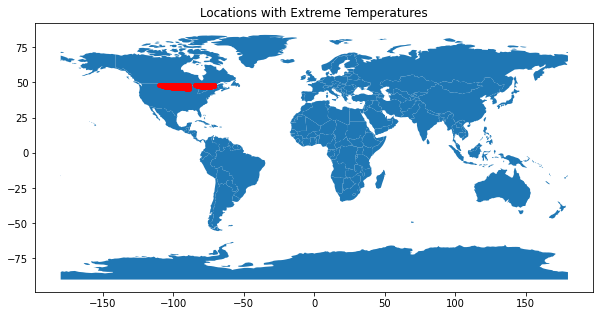

In [307]:
geometry = [Point(xy) for xy in zip(frame_out['lon'], frame_out['lat'])]
gdf = GeoDataFrame(frame_out, geometry=geometry)

extreme_gdf = gdf[(gdf['modified_z_scores'] > 3) | (gdf['modified_z_scores'] < -3)]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
extreme_gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_title('Locations with Extreme Temperatures')

In [144]:
df_copy.loc[df_copy['year'] == 1950]

,time,lat,lon,temperature,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,timeseries_ms_mode_imp,year,month,quarter
2690688,1950-01-16,26.25,-122.75,NaN,1,True,11.652020,12.700000,NaN,1950,1,1
2690689,1950-01-16,26.25,-122.25,NaN,1,True,11.652020,12.700000,NaN,1950,1,1
2690690,1950-01-16,26.25,-121.75,NaN,1,True,11.652020,12.700000,NaN,1950,1,1
2690691,1950-01-16,26.25,-121.25,NaN,1,True,11.652020,12.700000,NaN,1950,1,1
2690692,1950-01-16,26.25,-120.75,NaN,1,True,11.652020,12.700000,NaN,1950,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2745595,1950-12-16,47.75,-73.25,-10.700000,0,False,-10.700000,-10.700000,-10.700000,1950,12,4
2745596,1950-12-16,47.75,-72.75,-10.500000,0,False,-10.500000,-10.500000,-10.500000,1950,12,4
2745597,1950-12-16,47.75,-72.25,-10.900001,0,False,-10.900001,-10.900001,-10.900001,1950,12,4
2745598,1950-12-16,47.75,-71.75,-10.900001,0,False,-10.900001,-10.900001,-10.900001,1950,12,4


In [ ]:
df_copy['timeseries-tas-monthly-mean_missing'].rename({'False': 0, 'True': 1}, axis=0, inplace=True)
df_copy = df_copy.drop(['time', 'timeseries_ms_mode_imp'], axis=1)

In [170]:
unique_year = df_copy['year'].unique()

results_df = pd.DataFrame(columns=['Year', 'MSE', 'RMSE', 'MAE', 'R2'])
preds = pd.DataFrame(columns=['Temperature'])

for i in tqdm(unique_year):
    yearly_data = df_copy.loc[df_copy['year'] == i, :]
    
    data_to_use = yearly_data.loc[yearly_data['temperature'].notna(), :]
    data_to_pred = yearly_data.loc[yearly_data['temperature'].isna(), :]
    
    features = data_to_use.drop('temperature', axis=1)
    target = data_to_use['temperature']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)
    
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_pred, y_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    r_squared = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    
    data_to_pred.drop(['temperature'], axis=1, inplace=True)
    data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
    y_pred = data_to_pred.loc[:, 'temperature']
    
    preds = preds.append({'Temperature': y_pred}, ignore_index=True)

    results_df = results_df.append({'Year': i,
                                    'MSE': mse,
                                    'RMSE': rmse, 
                                    'MAE': mae,
                                    'R2': r_squared}, ignore_index=True)
    
results_df = results_df.set_index('year')

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

  5%|████                                                                              | 6/120 [00:03<01:05,  1.73it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 10%|████████                                                                         | 12/120 [00:06<01:02,  1.74it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 15%|████████████▏                                                                    | 18/120 [00:10<01:03,  1.61it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 20%|████████████████▏                                                                | 24/120 [00:14<01:13,  1.31it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 25%|████████████████████▎                                                            | 30/120 [00:20<01:21,  1.10it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 30%|████████████████████████▎                                                        | 36/120 [00:26<01:16,  1.09it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 35%|████████████████████████████▎                                                    | 42/120 [00:31<01:10,  1.10it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 40%|████████████████████████████████▍                                                | 48/120 [00:37<01:07,  1.07it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 45%|████████████████████████████████████▍                                            | 54/120 [00:42<00:58,  1.12it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 50%|████████████████████████████████████████▌                                        | 60/120 [00:47<00:54,  1.11it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 55%|████████████████████████████████████████████▌                                    | 66/120 [00:52<00:46,  1.17it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 60%|████████████████████████████████████████████████▌                                | 72/120 [00:57<00:40,  1.20it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 65%|████████████████████████████████████████████████████▋                            | 78/120 [01:02<00:34,  1.22it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 70%|████████████████████████████████████████████████████████▋                        | 84/120 [01:07<00:29,  1.21it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:12<00:24,  1.21it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 80%|████████████████████████████████████████████████████████████████▊                | 96/120 [01:17<00:20,  1.17it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 85%|████████████████████████████████████████████████████████████████████            | 102/120 [01:22<00:15,  1.20it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 90%|████████████████████████████████████████████████████████████████████████        | 108/120 [01:28<00:10,  1.18it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

 95%|████████████████████████████████████████████████████████████████████████████    | 114/120 [01:32<00:04,  1.22it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.drop(['temperature'], axis=1, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_pred.loc[:, 'temperature'] = model.predict(data_to_pred)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5112\1206569309.py:33: FutureWarning: The frame.append 

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:38<00:00,  1.22it/s]


KeyError: "None of ['year'] are in the columns"

In [171]:
results_df

,Year,MSE,RMSE,MAE,R2
0,1901.0,0.000173,0.013148,0.010068,0.999998
1,1902.0,0.000178,0.013342,0.010055,0.999998
2,1903.0,0.000181,0.013437,0.010226,0.999998
3,1904.0,0.000215,0.014664,0.010904,0.999998
4,1905.0,0.000217,0.014719,0.011281,0.999998
...,...,...,...,...,...
115,2016.0,0.000181,0.013443,0.009992,0.999998
116,2017.0,0.000167,0.012937,0.010015,0.999998
117,2018.0,0.000183,0.013533,0.010425,0.999998
118,2019.0,0.0002,0.01413,0.010736,0.999998


In [187]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    120 non-null    object
 1   MSE     120 non-null    object
 2   RMSE    120 non-null    object
 3   MAE     120 non-null    object
 4   R2      120 non-null    object
dtypes: object(5)
memory usage: 4.8+ KB


In [188]:
results_df['Year'] = results_df['Year'].astype('int64')
results_df['MSE'] = results_df['MSE'].astype('float64')
results_df['RMSE'] = results_df['RMSE'].astype('float64')
results_df['MAE'] = results_df['MAE'].astype('float64')
results_df['R2'] = results_df['R2'].astype('float64')

In [233]:
results_df.describe()

,Year,MSE,RMSE,MAE,R2
count,120.000000,120.000000,120.000000,120.000000,1.200000e+02
mean,1960.500000,0.000202,0.014161,0.010662,9.999982e-01
std,34.785054,0.000035,0.001221,0.000834,2.766546e-07
min,1901.000000,0.000138,0.011744,0.008982,9.999974e-01
25%,1930.750000,0.000178,0.013335,0.010105,9.999980e-01
50%,1960.500000,0.000198,0.014065,0.010693,9.999982e-01
75%,1990.250000,0.000227,0.015053,0.011193,9.999984e-01
max,2020.000000,0.000318,0.017841,0.013584,9.999987e-01


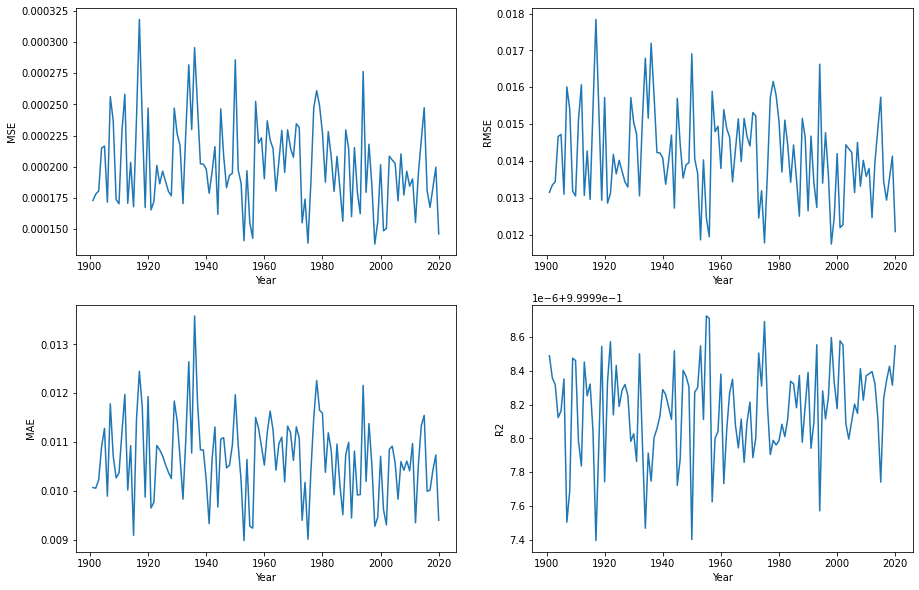

In [209]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].plot(results_df['Year'], results_df['MSE'])
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('MSE')
ax[0][1].plot(results_df['Year'], results_df['RMSE'])
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('RMSE')
ax[1][0].plot(results_df['Year'], results_df['MAE'])
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('MAE')
ax[1][1].plot(results_df['Year'], results_df['R2'])
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('R2')
plt.show()

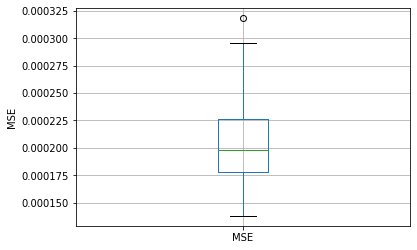

In [222]:
results_df.boxplot('MSE')
plt.ylabel('MSE')
plt.show()

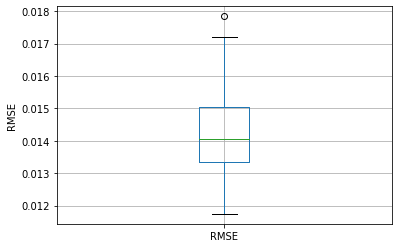

In [223]:
results_df.boxplot('RMSE')
plt.ylabel('RMSE')
plt.show()

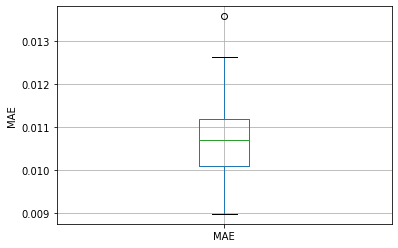

In [224]:
results_df.boxplot('MAE')
plt.ylabel('MAE')
plt.show()

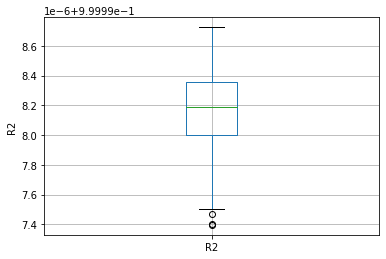

In [225]:
results_df.boxplot('R2')
plt.ylabel('R2')
plt.show()

In [226]:
results_df[['MSE', 'RMSE', 'MAE', 'R2']].corr()

,MSE,RMSE,MAE,R2
MSE,1.000000,0.998370,0.939171,-0.917504
RMSE,0.998370,1.000000,0.942819,-0.916497
MAE,0.939171,0.942819,1.000000,-0.810539
R2,-0.917504,-0.916497,-0.810539,1.000000


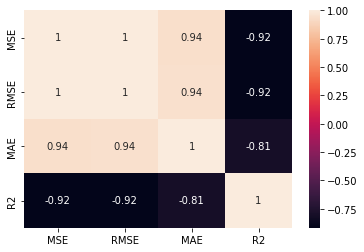

In [227]:
import seaborn as sns

sns.heatmap(results_df[['MSE', 'RMSE', 'MAE', 'R2']].corr(), annot=True)
plt.show()

In [235]:
df_copy.head()

,lat,lon,temperature,n_missing,timeseries-tas-monthly-mean_missing,temperature_ms_mean_imp,temperature_ms_median_imp,year,month,quarter
0,26.25,-122.75,NaN,1,True,11.65202,12.7,1901,1,1
1,26.25,-122.25,NaN,1,True,11.65202,12.7,1901,1,1
2,26.25,-121.75,NaN,1,True,11.65202,12.7,1901,1,1
3,26.25,-121.25,NaN,1,True,11.65202,12.7,1901,1,1
4,26.25,-120.75,NaN,1,True,11.65202,12.7,1901,1,1


In [244]:
frame_to_use = df_copy.dropna(axis=0)

In [254]:
frame_to_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5389920 entries, 20 to 6589439
Data columns (total 10 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   lat                                  float64
 1   lon                                  float64
 2   temperature                          float64
 3   n_missing                            int64  
 4   timeseries-tas-monthly-mean_missing  bool   
 5   temperature_ms_mean_imp              float64
 6   temperature_ms_median_imp            float64
 7   year                                 int64  
 8   month                                int64  
 9   quarter                              int64  
dtypes: bool(1), float64(5), int64(4)
memory usage: 416.4 MB


In [262]:
X = frame_to_use[['lat', 'lon', 'year', 'month', 'quarter']]
y = frame_to_use['temperature']

In [263]:
X = sm.add_constant(X)

In [264]:
model = sm.OLS(y, X).fit()

In [265]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 4.435e+05
Date:                Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:41:50   Log-Likelihood:            -1.9353e+07
No. Observations:             5389920   AIC:                         3.871e+07
Df Residuals:                 5389914   BIC:                         3.871e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6549      0.218    117.923      0.000      25.228      26.081
lat           -0.8887      0.001  -1376.504      0.000      -0.890      -0.887
lon            0.0216      0.000     77.530      0.000       0.021       0.022
year           0.0089      0.000     81.805      0.000       0.009       0.009
month         -0.0797      0.005    -17.224      0.000      -0.089      -0.071
quarter        2.1345      0.014    149.373      0.000       2.107       2.163
==============================================================================
Omnibus:                   709664.260   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196803.547
Skew:                          -0.153   Prob(JB):                         0.00
Kurtosis:                       2.115   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [271]:
error_r2 = results_df['R2']
stat, p = shapiro(error_r2)
print("Shapiro-Wilk test results:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("The errors are not normally distributed.")
else:
    print("The errors are normally distributed.")

Shapiro-Wilk test results:
Statistic: 0.1944, p-value: 0.0000
The errors are not normally distributed.


In [275]:
error_mse = results_df['MSE']
stat, p = shapiro(error_mse)
print("Shapiro-Wilk test results:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("The errors are not normally distributed.")
else:
    print("The errors are normally distributed.")

Shapiro-Wilk test results:
Statistic: 0.9760, p-value: 0.0303
The errors are not normally distributed.


In [276]:
error_rmse = results_df['RMSE']
stat, p = shapiro(error_rmse)
print("Shapiro-Wilk test results:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("The errors are not normally distributed.")
else:
    print("The errors are normally distributed.")

Shapiro-Wilk test results:
Statistic: 0.9879, p-value: 0.3651
The errors are normally distributed.


In [277]:
error_mae = results_df['MAE']
stat, p = shapiro(error_mae)
print("Shapiro-Wilk test results:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

if p < 0.05:
    print("The errors are not normally distributed.")
else:
    print("The errors are normally distributed.")

Shapiro-Wilk test results:
Statistic: 0.9861, p-value: 0.2596
The errors are normally distributed.
